In [40]:
print('start')
import torch
import numpy as np
from PIL import Image
import imagehash
import cv2
from shutil import rmtree
from os import mkdir,path
import matplotlib.pyplot as plt

%matplotlib inline


from torchvision import models, transforms

start


## prepare files

In [41]:
if path.isdir('test'):
    rmtree('test')
if path.isdir('results'):
    rmtree('results')

In [42]:
mkdir('test')
mkdir('test/small')
mkdir('test/crop')
mkdir('results')

In [43]:
color=(0,0,255)
thickness=2

In [44]:
small_picture = Image.open('data/1-small.png').convert('RGB')
big_picture = Image.open('data/1-big.png').convert('RGB')

## prepare model

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True).to(device)

# co robi to niżej?
model = torch.nn.Sequential(*(list(model.children())[:-2])).to(device)

In [46]:
# for i in range(0,256-64,5):
        
#     for j in range(0,256-64,5):
        
#         left=i
#         right = i+ 64
        
#         top=j
#         bottom = j+64
        
#         start_point=(left,top)
#         end_point=(right,bottom)
        
#         crop=big.crop((left,top,right,bottom))

# #         hash0=imagehash.average_hash(small)
#         hash1=imagehash.average_hash(crop)
#         for r in range(0,360,5):
            
#             small_test=small.rotate(r)
#             small_test=small_test.resize((64,64))
# #             small_test=small

#             hash0=imagehash.average_hash(small_test)
            
           
#             if hash0 - hash1 <12:
#                 cv_big = np.array(big_color.convert('RGB'))
#                 cv_big=cv_big[:,:,::-1].copy()

#                 result=cv2.rectangle(cv_big,start_point,end_point,color,thickness)
#                 result = cv2.cvtColor(result,cv2.COLOR_BGR2RGB)
#                 big_color=Image.fromarray(result)

#                 small_test.save('test/small/{}-{}-{}.png'.format(i,j,r))
#                 crop.save('test/crop/{}-{}-{}.png'.format(i,j,r))
                
#                 print(start_point,end_point)
#                 break
            
        



In [47]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = transforms.Compose([
#     transforms.CenterCrop(10),
    transforms.ToTensor(),
    normalize
])

## working with photos

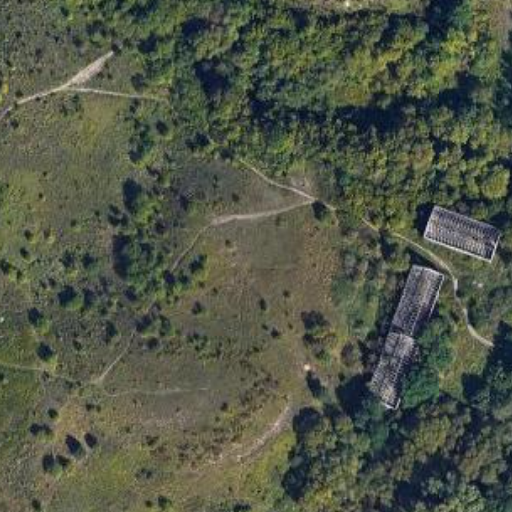

In [48]:
big_picture

In [74]:
big_picture.size

(512, 512)

In [49]:
big_picture_torch = data_transforms(big_picture).to(device)

In [50]:
big_picture_torch.size()

torch.Size([3, 512, 512])

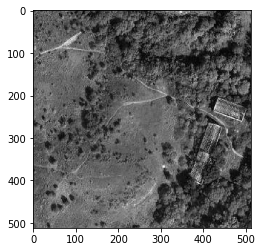

In [51]:
plt.imshow(big_picture_torch.numpy()[0], cmap='gray')

In [52]:
big_picture_torch.unsqueeze(0).size()

torch.Size([1, 3, 512, 512])

## resnet

In [53]:
resnet_out_big=model(big_picture_torch.unsqueeze(0)).squeeze()

In [54]:
resnet_out_big.size()

torch.Size([2048, 16, 16])

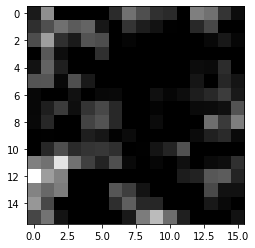

In [55]:
plt.imshow(resnet_out_big.detach().numpy()[0], cmap='gray')

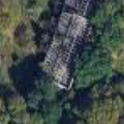

In [56]:
small_picture

In [57]:
small_picture.size

(124, 124)

In [58]:
small_picture.rotate(30).show()

In [59]:
small_pictures_rotated_torch = []
for rotate_angle in range(0,360,10):
    small_picture_rotated = small_picture.rotate(rotate_angle)
    small_pictures_rotated_torch.append(data_transforms(small_picture_rotated))

In [60]:
small_pictures_rotated_torch[0].size()

torch.Size([3, 124, 124])

In [61]:
# ,,Total number of training examples present in a single batch"
small_pictures_batch = torch.stack(small_pictures_rotated_torch).to(device)

# Czemu to device?

In [62]:
small_pictures_batch.size()

torch.Size([36, 3, 124, 124])

In [63]:
resnet_outs_small = model(small_pictures_batch)

In [64]:
resnet_outs_small.size()

torch.Size([36, 2048, 4, 4])

## model outputs

In [65]:
h_big, w_big = resnet_out_big.size()[1:]
h_big, w_big

(16, 16)

In [66]:
resnet_out_big.size()

torch.Size([2048, 16, 16])

In [73]:
for small_picture_resnet in resnet_outs_small:
    h_small, w_small = small_picture_resnet.size()[1:]
#     print(h_small,w_small)
    
    for h_shift in range(h_big-h_small):
        for w_shift in range(w_big-w_small):
            resnet_out_big_cut=resnet_out_big[:, h_shift:h_shift+h_small, w_shift:w_shift+w_small]
            similarity_measure = torch.mean((resnet_out_big_cut - small_picture_resnet) ** 2).item()
#             print(similarity_measure)
            if similarity_measure<0.5:
#                 print(similarity_measure,resnet_out_big_cut)
                print(resnet_out_big_cut.size(),w_shift,h_shift)
#                 plt.imshow(resnet_out_big_cut.detach().numpy()[0], cmap='gist_yarg')
                
            
        
        
    
    

torch.Size([2048, 4, 4]) 5 0
torch.Size([2048, 4, 4]) 5 1
torch.Size([2048, 4, 4]) 5 2
torch.Size([2048, 4, 4]) 0 5
torch.Size([2048, 4, 4]) 0 6
torch.Size([2048, 4, 4]) 8 6
torch.Size([2048, 4, 4]) 7 7
torch.Size([2048, 4, 4]) 8 7
torch.Size([2048, 4, 4]) 7 8
torch.Size([2048, 4, 4]) 9 6
torch.Size([2048, 4, 4]) 0 6
torch.Size([2048, 4, 4]) 0 5
torch.Size([2048, 4, 4]) 0 6
